In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import cv2
from albumentations import Rotate
from scipy import ndimage
import imutils
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
from skimage.morphology import medial_axis, skeletonize, thin, remove_small_objects
from rdp import rdp
import rdp
from csaps import csaps

In [39]:
sine = np.zeros((210,210))

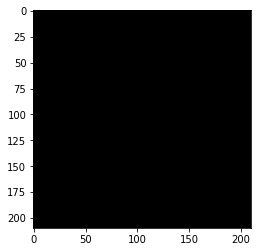

In [40]:
plt.imshow(sine,cmap = 'gray')

In [41]:
y0 = 105
for i in range(210):
    sine[y0 + int(4*np.sin(np.pi*i/20))][i] = 1

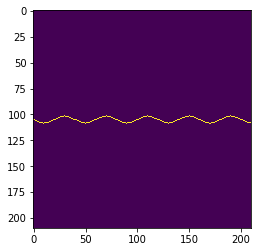

In [42]:
plt.imshow(sine)

In [43]:
# img_path = sorted(glob.glob('centered_imgs/*/*'))
#  img_path = sorted(glob.glob('FAZ-master/FAZ_Tortuosity/*')) #Original Folder

In [44]:
masked_data = sine

In [45]:
def get_points(skeleton_image):
    cnts = cv2.findContours(skeleton_image.copy().astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)
    return cnts

In [46]:
def num_to_str(contour):
    str_list = list()
    for c in contour:
        str_list.append(str(c[0][0])+','+str(c[0][1]))
    return str_list

def get_unique(contour):
    cont = contour.copy()
    str_list = num_to_str(cont)
    index_dict = dict()
    for i in range(len(str_list)):
        if str_list[i] not in index_dict.keys():
            index_dict[str_list[i]] = i
    new_dict = dict((val,key) for key,val in index_dict.items())
    sub_cont = list()
    keys = list(new_dict.keys())
    keys.sort()
    sub_cont.append(list())
    last_ind = 0
    sub_cont[last_ind].append(new_dict[keys[0]])
    for i in range(len(keys)-1):
        if keys[i+1]-keys[i]!=1:
            last_ind+=1
            sub_cont.append(list())
            sub_cont[last_ind].append(new_dict[keys[i+1]])
        else:
            sub_cont[last_ind].append(new_dict[keys[i+1]])
    num_cont = sub_cont.copy()
    for l in range(len(num_cont)):
        for s in range(len(num_cont[l])):
            nums = num_cont[l][s].split(',')
            x = int(nums[0])
            y = int(nums[1])
            num_cont[l][s] = [x,y]
    return num_cont

In [47]:
def angle(dir):
    """
    Returns the angles between vectors.

    Parameters:
    dir is a 2D-array of shape (N,M) representing N vectors in M-dimensional space.

    The return value is a 1D-array of values of shape (N-1,), with each value
    between 0 and pi.

    0 implies the vectors point in the same direction
    pi/2 implies the vectors are orthogonal
    pi implies the vectors point in opposite directions
    """
    dir2 = dir[1:]
    dir1 = dir[:-1]
    return np.arccos((dir1*dir2).sum(axis=1)/(np.sqrt((dir1**2).sum(axis=1)*(dir2**2).sum(axis=1))))

In [48]:
def get_turning_points_contour(contour, tolerance, min_angle):
    points = np.array(contour)
    simplified = np.array(rdp.rdp(points.tolist(), tolerance))
    sx, sy = simplified.T
    # compute the direction vectors on the simplified curve
    directions = np.diff(simplified, axis=0)
    theta = angle(directions)
    # Select the index of the points with the greatest theta
    # Large theta is associated with greatest change in direction.
    idx = np.where(theta>min_angle)[0]+1
    return np.array([sx[idx], sy[idx]])

def get_turning_points(image, tolerance, min_angle):
    contours = get_points(image)
    corner_points = []
    for contour in contours:
        uniques = get_unique(contour)
        for unique in uniques:
            corner_point = get_turning_points_contour(unique, tolerance, min_angle)
            if corner_point.size != 0:
                corner_points.append(corner_point.T)
                
    points = []
    for pt in corner_points:
        for p in pt:
            points.append(p)
    points = np.array(points)
    return points

In [49]:
points = get_turning_points(masked_data, tolerance = 2, min_angle = np.pi*0.15)

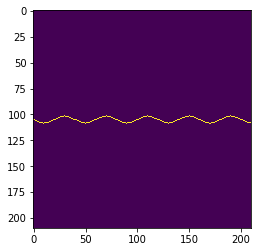

In [50]:
plt.imshow(masked_data)

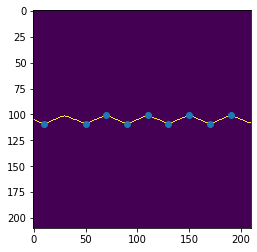

In [51]:
plt.scatter(points.T[0],points.T[1])
plt.imshow(masked_data,cmap='gray')
plt.imshow(masked_data)

# Retipy Functions:

In [52]:
import math
import numpy as np

def _distance_2p(x1, y1, x2, y2):
    """
    calculates the distance between two given points
    :param x1: starting x value
    :param y1: starting y value
    :param x2: ending x value
    :param y2: ending y value
    :return: the distance between [x1, y1] -> [x2, y2]
    """
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5


def _curve_length(x, y):
    """
    calculates the length(distance) of the given curve, iterating from point to point.
    :param x: the x component of the curve
    :param y: the y component of the curve
    :return: the curve length
    """
    distance = 0
    for i in range(0, len(x) - 1):
        distance += _distance_2p(x[i], y[i], x[i + 1], y[i + 1])
    return distance


def _chord_length(x, y):
    """
    distance between starting and end point of the given curve
    :param x: the x component of the curve
    :param y: the y component of the curve
    :return: the chord length of the given curve
    """
    return _distance_2p(x[0], y[0], x[len(x) - 1], y[len(y) - 1])


def _detect_inflection_points(x, y):
    """
    This method detects the inflection points of a given curve y=f(x) by applying a convolution to
    the y values and checking for changes in the sign of this convolution, each sign change is
    interpreted as an inflection point.
    It will ignore the first and last 2 pixels.
    :param x: the x values of the curve
    :param y: the y values of the curve
    :return: the array position in x of the inflection points.
    """
    cf = np.convolve(y, [1, -1])
    inflection_points = []
    for iterator in range(2, len(x)):
        if np.sign(cf[iterator]) != np.sign(cf[iterator - 1]):
            inflection_points.append(iterator - 1)
    return inflection_points




# Segments(Particular contour)

In [53]:
"""
First get a particular contour
get unique points
get the turning points 
total number of turning points = n
total length of segment = Lt
divide in smaller segments: search for inflection point and slice the contour
calculate arc length and chord length
formula = (n-1)/Lt(sum)(arc(l)/chord(l) - 1)

"""

'\nFirst get a particular contour\nget unique points\nget the turning points \ntotal number of turning points = n\ntotal length of segment = Lt\ndivide in smaller segments: search for inflection point and slice the contour\ncalculate arc length and chord length\nformula = (n-1)/Lt(sum)(arc(l)/chord(l) - 1)\n\n'

In [54]:
all_contours = get_points(masked_data)

In [55]:
all_contours[0]

array([[[ 30, 101]],

       [[ 29, 102]],

       [[ 28, 102]],

       [[ 27, 102]],

       [[ 26, 102]],

       [[ 25, 103]],

       [[ 24, 103]],

       [[ 23, 104]],

       [[ 22, 104]],

       [[ 21, 105]],

       [[ 20, 105]],

       [[ 19, 105]],

       [[ 18, 106]],

       [[ 17, 106]],

       [[ 16, 107]],

       [[ 15, 107]],

       [[ 14, 108]],

       [[ 13, 108]],

       [[ 12, 108]],

       [[ 11, 108]],

       [[ 10, 109]],

       [[  9, 108]],

       [[  8, 108]],

       [[  7, 108]],

       [[  6, 108]],

       [[  5, 107]],

       [[  4, 107]],

       [[  3, 106]],

       [[  2, 106]],

       [[  1, 105]],

       [[  0, 105]],

       [[  1, 105]],

       [[  2, 106]],

       [[  3, 106]],

       [[  4, 107]],

       [[  5, 107]],

       [[  6, 108]],

       [[  7, 108]],

       [[  8, 108]],

       [[  9, 108]],

       [[ 10, 109]],

       [[ 11, 108]],

       [[ 12, 108]],

       [[ 13, 108]],

       [[ 14, 108]],

       [[ 

In [56]:
all_unique = list()
for cont in all_contours:
    u = get_unique(cont)
    for s in u:
        if len(s)>3:
            all_unique.append(s)

In [57]:
all_unique

[[[30, 101],
  [29, 102],
  [28, 102],
  [27, 102],
  [26, 102],
  [25, 103],
  [24, 103],
  [23, 104],
  [22, 104],
  [21, 105],
  [20, 105],
  [19, 105],
  [18, 106],
  [17, 106],
  [16, 107],
  [15, 107],
  [14, 108],
  [13, 108],
  [12, 108],
  [11, 108],
  [10, 109],
  [9, 108],
  [8, 108],
  [7, 108],
  [6, 108],
  [5, 107],
  [4, 107],
  [3, 106],
  [2, 106],
  [1, 105],
  [0, 105]],
 [[31, 102],
  [32, 102],
  [33, 102],
  [34, 102],
  [35, 103],
  [36, 103],
  [37, 104],
  [38, 104],
  [39, 105],
  [40, 105],
  [41, 105],
  [42, 106],
  [43, 106],
  [44, 107],
  [45, 107],
  [46, 108],
  [47, 108],
  [48, 108],
  [49, 108],
  [50, 109],
  [51, 108],
  [52, 108],
  [53, 108],
  [54, 108],
  [55, 107],
  [56, 107],
  [57, 106],
  [58, 106],
  [59, 105],
  [60, 105],
  [61, 105],
  [62, 104],
  [63, 104],
  [64, 103],
  [65, 103],
  [66, 102],
  [67, 102],
  [68, 102],
  [69, 102],
  [70, 101],
  [71, 102],
  [72, 102],
  [73, 102],
  [74, 102],
  [75, 103],
  [76, 103],
  [77, 1

In [58]:

def makeImage(uniqueCont,shape):
    zeros = np.zeros(shape,dtype=bool)
#     print(len(uniqueCont))
    for pixel in uniqueCont:
#         print(pixel[1],pixel[0])
#         print(pixel)
        x = pixel[1]
        y = pixel[0]
        zeros[x,y] = True
#     plt.imshow(zeros,cmap='gray')
    return zeros


In [59]:
segments = list()
for unique in all_unique:
#     print(unique)
    segments.append(makeImage(unique,masked_data.shape))

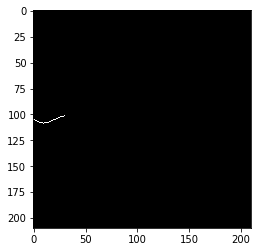

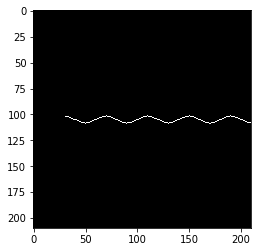

In [60]:
for segment in segments:
    plt.imshow(segment,cmap='gray')
    plt.show()

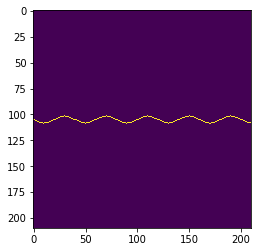

In [61]:
plt.imshow(masked_data)

In [62]:
zeros = np.zeros(masked_data.shape)

In [63]:
for s in segments:
    zeros[s] = 1

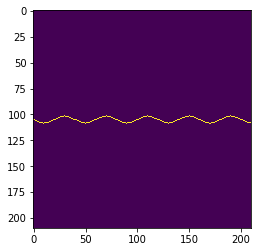

In [64]:
plt.imshow(zeros)

# Turning Points

In [65]:
turning_points = list()
for s in segments:
    segment = np.zeros(masked_data.shape)
    segment[s] = 1
    turning_points.append(get_turning_points(segment, tolerance = 2, min_angle = np.pi*0.15))
turning_points = np.array(turning_points)

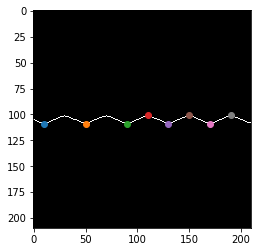

In [66]:
zeros = np.zeros(masked_data.shape)
for s in segments:
    zeros[s] = 1
for listTP in turning_points:
    for tp in listTP:
        plt.scatter(tp.T[0],tp.T[1])
plt.imshow(zeros,cmap='gray')

# Total length of contours:

In [67]:
def getXY(segment):
    x = list()
    y = list()
    for p in segment:
        x.append(p[0])
        y.append(p[1])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [68]:
curveLengths = list()
for s in all_unique:
    ux,uy = getXY(s)
    cl = _curve_length(ux,uy)
    curveLengths.append(cl)

In [69]:
curveLengths

[34.97056274847714, 206.99494936611688]

# Getting the Curvature for inflection points:

$K = \frac{{\left| {x’y^{\prime\prime} – y’x^{\prime\prime}} \right|}}{{{{\left[ {{{\left( {x’} \right)}^2} + {{\left( {y’} \right)}^2}} \right]}^{\large\frac{3}{2}\normalsize}}}}.$

In [70]:
def dist(x1,y1,x2,y2):
    del_x = x1-x2
    del_y = y1-y2
    return np.sqrt(del_x**2 + del_y**2)

def tortousity(cont1):
    x,y = getXY(cont1)
    index = list(range(len(x)))
    index2 = np.linspace(index[0],index[-1],5000)
    xs = csaps(index,x, index2, smooth=0.01)
    ys = csaps(index,y, index2, smooth=0.01)
    smoothX = xs
    smoothY = ys
    dx = np.diff(smoothX)
    dy = np.diff(smoothY)
    dx2 = (dx[0:-1] + dx[1:])/2
    dy2 = (dy[0:-1] + dy[1:])/2
    dx = dx[:-1]
    dy = dy[:-1]
    k = np.divide((np.multiply(dx ,dy2) - np.multiply(dx2 ,dy)) ,  np.power((np.square(dx) + np.square(dx) ),3/2))
    float_ip = list()
    inflection_index = list()
    for i in range(len(k)-1):
        if k[i]*k[i+1]<0:
           float_ip.append([smoothX[i+1],smoothY[i+1]])
           inflection_index.append(i+1)
    # used fro plotting:
    actual_ip = list()
    for fip in float_ip:
        min_dist = dist(fip[0],fip[1],cont1[0][0],cont1[0][1])
        minx = cont1[0][0]
        miny = cont1[0][1]
        for i in range(len(cont1)):
            d = dist(fip[0],fip[1],cont1[i][0],cont1[i][1])
    #         print(cont1[i][0],cont1[i][1])
    #         print(d)
            if d<=min_dist:
                minx = cont1[i][0]
                miny = cont1[i][1]
                min_dist = d
        actual_ip.append([minx,miny])
    n = len(inflection_index) +1
    total_cl = _curve_length(smoothX,smoothY)
    tort = (n-1)/(n*total_cl)
    dm = 0
    if n==1:
        al = _curve_length(smoothX,smoothY)
        cl = dist(smoothX[0],smoothY[0],smoothX[-1],smoothY[-1])
        dm+=al/cl-1
    #     print(dm)
    elif n==2:
        ind = inflection_index[0]
        al = _curve_length(smoothX[:ind],smoothY[:ind])
        cl = dist(smoothX[0],smoothY[0],smoothX[ind],smoothY[ind])
        dm+=al/cl
        al = _curve_length(smoothX[ind:],smoothY[ind:])
        cl = dist(smoothX[ind],smoothY[ind],smoothX[-1],smoothY[-1])
        dm+=al/cl-1
    #     print(dm)
    else:
        ind = inflection_index[0]
        al = _curve_length(smoothX[:ind],smoothY[:ind])
        cl = dist(smoothX[0],smoothY[0],smoothX[ind],smoothY[ind])
        dm+=al/cl-1
        last = ind
        for ind1 , ind2 in zip(inflection_index[:-1],inflection_index[1:]):
            ind = inflection_index[0]
            al = _curve_length(smoothX[ind1:ind2],smoothY[ind1:ind2])
            cl = dist(smoothX[ind1],smoothY[ind1],smoothX[ind2],smoothY[ind2])
            dm+=al/cl-1
            last = ind2
        al = _curve_length(smoothX[last:],smoothY[last:])
        cl = dist(smoothX[last],smoothY[last],smoothX[-1],smoothY[-1])
        dm+=al/cl-1
    tort*=dm
    
    
    turning_points_num = 0
    turning_points = list()
    
    segment = makeImage(cont1,(210,210))
    
    zeros = np.zeros((210,210))
    
    zeros[segment] = 1
    
    turning_points = get_turning_points(zeros, tolerance = 2, min_angle = np.pi*0.15)
    turning_points_num = len(turning_points)
    
    
    return tort, dm , actual_ip , turning_points_num


In [71]:
tortousity(all_unique[1])

(0.0020310709095785213,
 0.4248740081052391,
 [[40, 105],
  [60, 105],
  [80, 105],
  [100, 105],
  [120, 105],
  [140, 105],
  [160, 105],
  [180, 105],
  [200, 105]],
 7)

0.0009450653697332102 0.04504554788428883


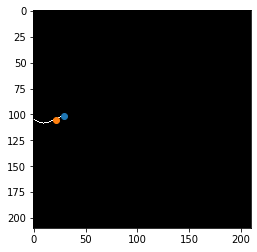

0.0020310709095785213 0.4248740081052391


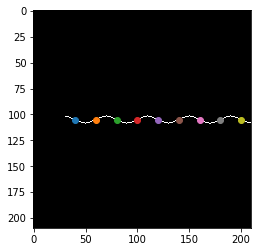

In [72]:
for j in range(len(all_unique)):
    tort,dm,ip,tp = tortousity(all_unique[j])
    print(tort,dm)
    segment = makeImage(all_unique[j],(210,210))
    for i in ip:
        plt.scatter(i[0],i[1])
    plt.imshow(segment,cmap='gray')
    plt.show()